# Safari

**Setting up the environment**
Initialization of the Ontology editor in Jupyter Notebook

In [1]:
from cognipy.ontology import Ontology #the ontology processing class
from cognipy.ontology import CQL #SPARQL format tailored for Contolled Natural Language
from cognipy.ontology import encode_string_for_graph_label #complex datatypes encoder for the graph labels in graph visualisation
import textwrap

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

### African Wildlife.
Loading the editor for the basic "safari" ontology. The Ontology is inspired by 'A Semantic Web Primer.' by 'Antoniou, G, van Harmelen, F.' 'MIT Press, 2003.' 'http://www.csd.uoc.gr/~hy566/SWbook.pdf', tuned to OWL/RL+SWRL profile.

### Part-1: 'simple hierarchy of beings'. 

Lets setup the fist ontology editor for the general knowledge.

In [2]:
%%writefile part_01.encnl

Namespace: 'http://cognitum.eu/african_wildlife'.

Comment: 'Let's name our instances'.
Comment: 'Let's specify the hierarchy of beings'. 
Comment: 'What is what?'.
Every man has a train.
Every lion is an animal.
Every giraffe is an animal.

Every animal has a face. 

Comment: 'Moreover'.
Every impala is an animal.
Every omnivore is an animal. 
Every rock-dassie is an animal.
Every warthog is an animal.
Every carnivore is an animal.
Every herbivore is an animal.
Every elephant is a herbivore.
Every lion is carnivore.

Comment: 'There are also plants there:'.
Every tree is a plant.
Every grass is a plant.
Every palm-tree is a plant.

Every branch is a plant-part.
Every leaf is a plant-part.
Every twig is a plant-part.

Every phloem is a plant-part.
Every root is a plant-part.
Every parsnip is a root.
Every stem is a plant-part.
Every xylem is a plant-part.
Every fruiting-body is a plant-part.
Every berry is a fruiting-body.
Every apple is a fruiting-body.

Comment: 'We cannot use adjectives directly. To specify adjectives we need to transform them into sets that have form of buzzy-words'.
Every tasty-plant is a plant.
Every carnivorous-plant is a plant.


Overwriting part_01.encnl


The ontology object alows you to draw the materialised graph using several layout algorythms. Lets draw our base ontology.

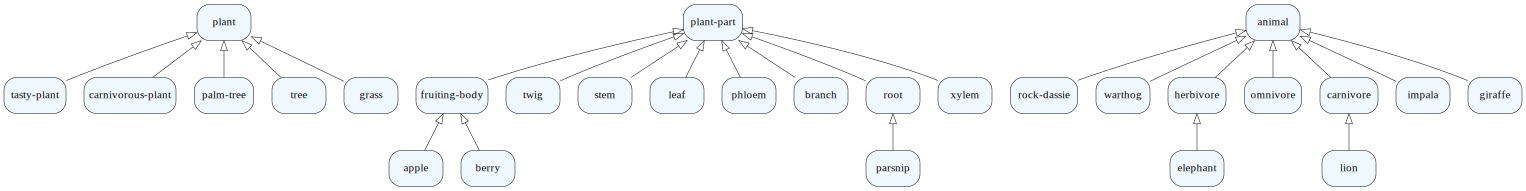

In [3]:
onto=Ontology("cnl/file","part_01.encnl", 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

onto.draw_graph(layout='hierarchical')

It is fully compatible with OWL/RDF format (via OWLAPI). We can always export it as it is.

### Part-2: Disjointness
In OWL/RL+SWRL profile we deal with Open World Assumption. It means that we need to explicitly specify all the objects that are different from each other. We cannot assume (like e.g. object oriented programming language do) that the different names mean the different things, therefore we need to specify explicitly if two things are different.

In [4]:
%%writefile part_02.encnl

Every-single-thing that is a plant and-or is a plant-part is a herb.
No herb is an animal.

Every carnivore eats nothing-but animals.
Every lion eats nothing-but herbivores.

Every herbivore eats nothing-but herb.

Anything either is a carnivore, is a herbivore or is an omnivore or-something-else.
Anything either is a branch, is a leaf or is a twig or-something-else.

No giraffe is a lion.
Every palm-tree is not a tree.

Overwriting part_02.encnl


Lets test how it works on the example. The example will be defining several instances, that aim to break the consistency of the ontology in som not obvious way.

In [5]:
%%writefile test_01.encnl

Leo-01 is a lion.
Leo-01 eats Sophie-01.
Sophie-01 is a giraffe.
Leo-01 eats Mary-01.
Mary-01 is a palm-tree.

Overwriting test_01.encnl


Lets load all the parts ontology ontology togheter with the testing part into the newly created obeject. 

In [6]:
onto=Ontology("cnl/string",'\n'.join(open(fn,"rt").read() for fn in ["part_01.encnl","part_02.encnl","test_01.encnl"]), 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

We will need also some way to describe what is wrong `printReasoningInfo` and why `printWhy`.

In [7]:
import json

def printReasoningInfo(onto):
    info=onto.reasoningInfo()
    if info == "":
        print('all good!')
    else:
        print(json.dumps(json.loads(info), indent=2, sort_keys=True))

def printWhy(onto,fact):
    info=json.loads(onto.why(fact))
    print(json.dumps(info, indent=2, sort_keys=True))

So what is wrong here?

In [8]:
printReasoningInfo(onto)

{
  "errors": [
    {
      "content": "Complement classes",
      "title": "inconsistency",
      "vals": {
        "concept": "animal",
        "instance": "Mary-01"
      }
    }
  ]
}


Lets draw it on a diagram, this time using force directed layout.

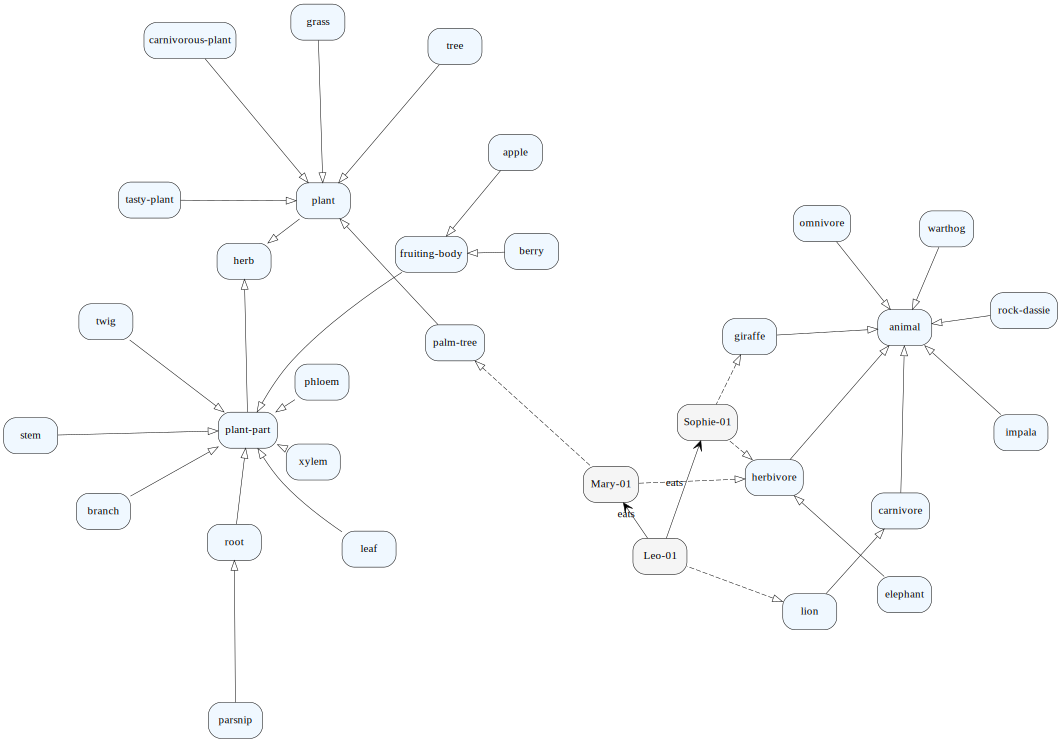

In [9]:
onto.draw_graph(layout='force directed')

In [10]:
printWhy(onto,"Mary-01 is a animal?")

{
  "by": [
    {
      "expr": "Every carnivore eats nothing-but animals."
    },
    {
      "expr": "Every carnivore eats nothing-but animals."
    },
    {
      "expr": "Leo-01 eats Mary-01."
    },
    {
      "by": [
        {
          "by": [
            {
              "expr": "Every lion is a carnivore."
            },
            {
              "expr": "Every carnivore eats nothing-but animals."
            }
          ]
        },
        {
          "expr": "Leo-01 is a lion."
        }
      ]
    }
  ],
  "concluded": "Mary-01 is an animal."
}


### Part-3: Modal expressions and part-whole relationships.

In [11]:
%%writefile part_03.encnl

Every carnivorous-plant must eat an animal.
Every carnivor must eat an animal.
Every omnivore must eat a plant.
Every branch must be-part-of a tree.
Every plant-part must be-part-of a plant.

Comment: 'Role equivalence and inverted roles'.
X has-part Y if-and-only-if Y is-part-of X.
X eats Y if-and-only-if Y is-eaten-by X.

Comment: 'Role subsumptions'.
If X is-part-of Y then X is-part-of Y.
If X has-part something that has-part Y then X has-part Y.

Comment: 'Complex role subsumptions'.
If X is-part-of something that is-part-of Y then X is-part-of Y.

Overwriting part_03.encnl


In [12]:
%%writefile test_02.encnl

Leo-01 is a lion.
Leo-01 eats Sophie-01.
Sophie-01 is a giraffe.
Sophie-01 eats Leaf-01.
Mary-01 is a tree.
Leaf-01 is a leaf and is-part-of Branch-02.
Branch-02 is a branch and is-part-of Branch-01.
Branch-01 is a branch and is-part-of Mary-01.
Branch-03 is a branch.

Overwriting test_02.encnl


In [13]:
onto=Ontology("cnl/string",'\n'.join(open(fn,"rt").read() for fn in ["part_01.encnl","part_02.encnl","part_03.encnl","test_02.encnl"]), 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

In [14]:
printReasoningInfo(onto)

{
  "modals": {
    "Every branch must be-part-of a tree.\r\n": [
      {
        "?x0": {
          "instance": "Branch-03"
        }
      }
    ],
    "Every plant-part must be-part-of a plant.\r\n": [
      {
        "?x0": {
          "instance": "Branch-03"
        }
      }
    ]
  }
}


In [20]:
from IPython import display

In [23]:
display.HTML(onto.draw_graph(layout="force directed"))

TypeError: 'SVG' object is not subscriptable

In [18]:
q1_edit = CnlQueryForConcept('query_01.encnl',onto=onto)
q1_edit

In [16]:
onto.select_instances_of("eaten by Leo-01")

,Instance,is-eaten-by,eats
0,Sophie-01,Leo-01,Leaf-01


In [17]:
print(onto.why("Leo-01 is an animal?"))

{"concluded":"Leo-01 is an animal.","by":[
    {"expr":"Every lion is an animal."},
    {"expr":"Leo-01 is a lion."}]}




In [18]:
onto.sparql_query(CQL("""select ?a1 ?a2 {
                            ?a1 rdf:type <animal>. 
                            ?a2 rdf:type <animal>. 
                            ?a1 <eats> ?a2. 
                        }""","http://cognitum.eu/african_wildlife#"))

,a1,a2
0,Leo-01,Sophie-01


In [19]:
print(onto.as_rdf())

<?xml version = '1.0' encoding = 'UTF-8'?>
<rdf:RDF xmlns="http://cognitum.eu/african_wildlife#" xml:base="http://cognitum.eu/african_wildlife" xmlns:owl="http://www.w3.org/2002/07/owl#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">
  <owl:Ontology rdf:about="http://cognitum.eu/african_wildlife#" />
  <!-- 
    ///////////////////////////////////////////////////////////////////////////////////////
    //
    // Object Properties
    //
    ///////////////////////////////////////////////////////////////////////////////////////
     -->
  <!-- http://cognitum.eu/african_wildlife#eats -->
  <owl:ObjectProperty rdf:about="http://cognitum.eu/african_wildlife#eats">
    <owl:equivalentProperty>
      <rdf:Description>
        <owl:inverseOf rdf:resource="http://cognitum.eu/african_wildlife#isEatenBy" />
      </rdf:Description>
    </owl:equivalentProperty>
  </owl:ObjectProperty>
  <!